In [1]:
import numpy as np
import pandas as pd 
import copy
import os

import matplotlib.pyplot as plt
import seaborn as sns

from random import shuffle, randint

from numpy import mean, std, dstack

from pandas import read_csv

from keras import backend as K
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Model, Sequential
from keras.layers import (Input, Dense, Flatten, Dropout, Conv1D, LSTM, GRU,
                          TimeDistributed, GlobalAveragePooling1D, MaxPooling1D)
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

from keras.optimizers import Adam, RMSprop,SGD
from keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from scipy import signal

%matplotlib inline
with pd.option_context("display.max_rows", 10, "display.max_columns", 20):
    print(pd.get_option("display.max_rows")) 
    print(pd.get_option("display.max_columns"))
    
# Check GPU support 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python

10
20
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14368606121598936350
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12063305484600622022
physical_device_desc: "device: XLA_CPU device"
]


In [2]:
from os import chdir as cd
cd('..')

In [3]:
def display_block_of_values(dataframe=pd.DataFrame,
                            x_label='x_label',
                            y_label='y_label',
                            figsize=(15, 30),
                            plot_size=(30, 2)):
    """

    :param dataframe:
    :param x_label:
    :param y_label:
    :param figsize:
    :param plot_size:
    :return:
    """
    assert isinstance(dataframe, pd.DataFrame)
    plt.figure(figsize=figsize)
    for index, col in enumerate(dataframe.columns):
        plt.subplot(plot_size[0], plot_size[1], index+1)
        plt.plot(dataframe[col])
        plt.title(col)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.tight_layout()

# 1) Oil Pressure Reading Chart 

In [4]:
from seriem_temporis.controller import SignalController
signals = SignalController(filepath="datasets/L1_10-12.18.csv", 
                           rolling_window_size=500, 
                           minimal_anomaly_length=50, 
                           sample_rate=40, 
                           encoding="cp1251", 
                           delimiter=",", 
                           corr_threshold=0.9, 
                           smooth_method='savgol', 
                           target_variable=None)

Number of columns: 96
Number of columns after corr analysis: 52
Number of columns after clean: 41
NaN Values: False
Successfully scaled control_results
savgol filter smoothing successful


### Display smooth scaled signals

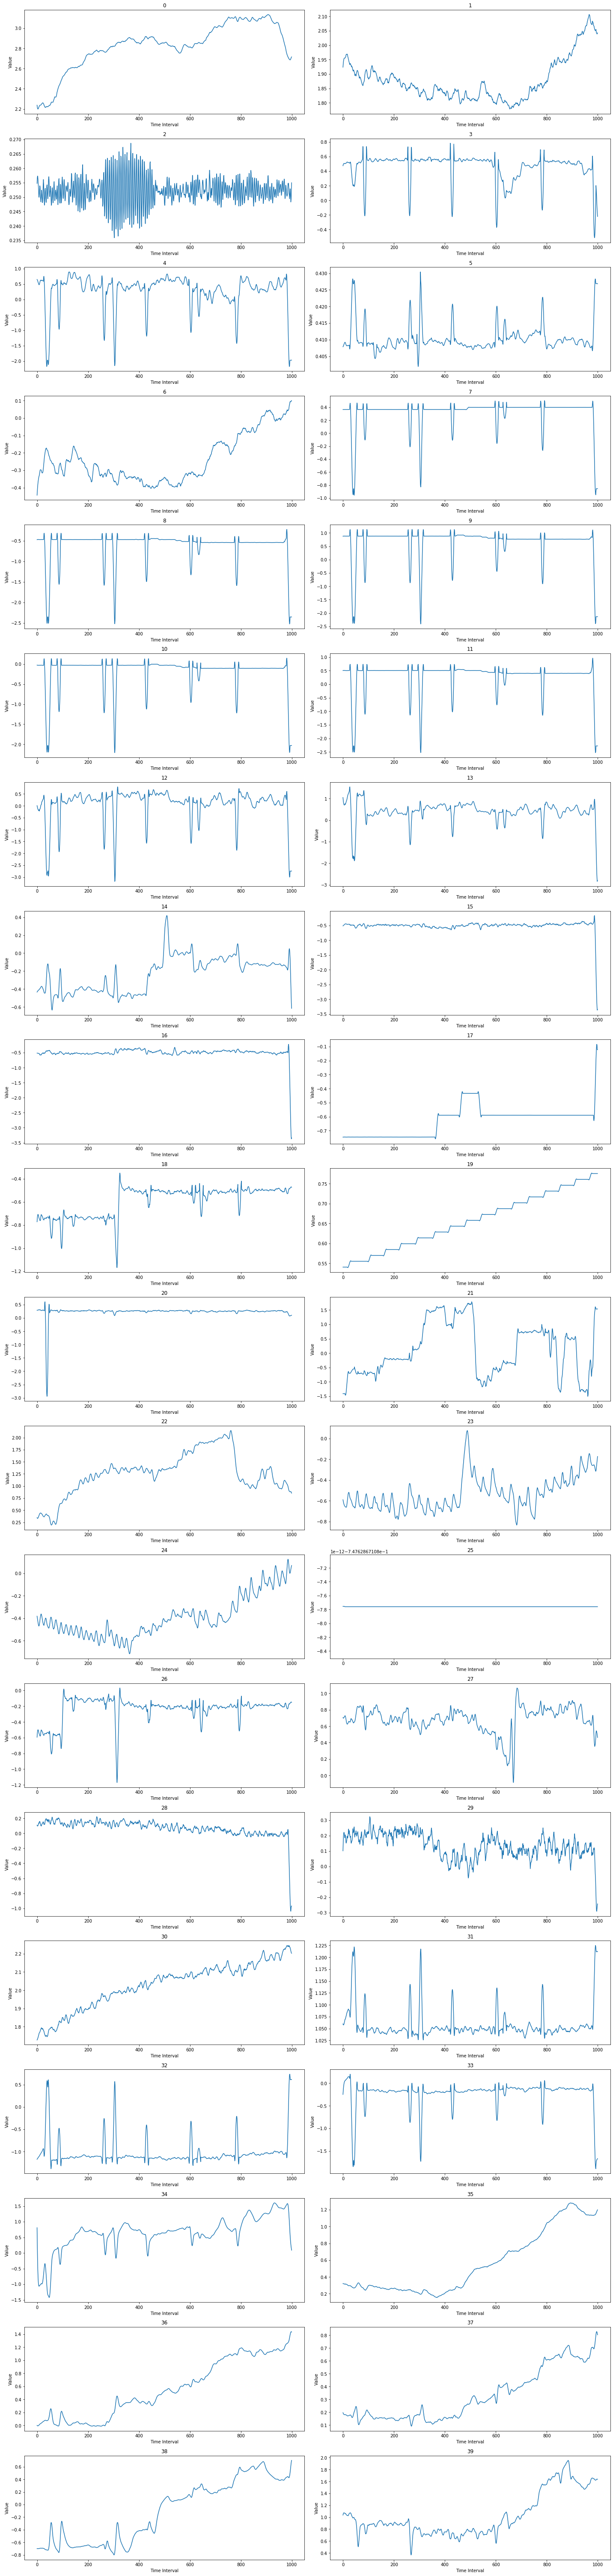

In [9]:
display_block_of_values(signals.smoothed_control_results.iloc[:1000],
              x_label='Time Interval',
              y_label='Value', 
              figsize=(20, 100),
              plot_size=(24,2))

generate some anomalies 

In [5]:
signal_samples = signals.get_sliced_signal
anomaly_signal_samples = signals.generate_anomalies(signal_samples)

In [6]:
print('Нормальных уастков: {} \nАномальных участков: {}'.format(len(signal_samples),len(anomaly_signal_samples)))

Нормальных уастков: 3298 
Аномальных участков: 3298


### Display scaled set with anomalies 

In [7]:
def display_signal_with_anomalies(samples , x_label='x_label', y_label='y_label',figsize=(15,30), plot_size=(15,3)):
    plt.figure(figsize=figsize)
    sample_number = 0
    print(samples.values.shape)
    for plot in range(plot_size[0]*plot_size[1]):
        plt.subplot(plot_size[0],plot_size[1], plot+1)
        plt.plot(signal_samples[1].values[:,plot])
        plt.plot(anomaly_signal_samples[1].values[: , plot])
        plt.title(plot)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.tight_layout()
        sample_number += 1

(500, 40)


IndexError: index 40 is out of bounds for axis 1 with size 40

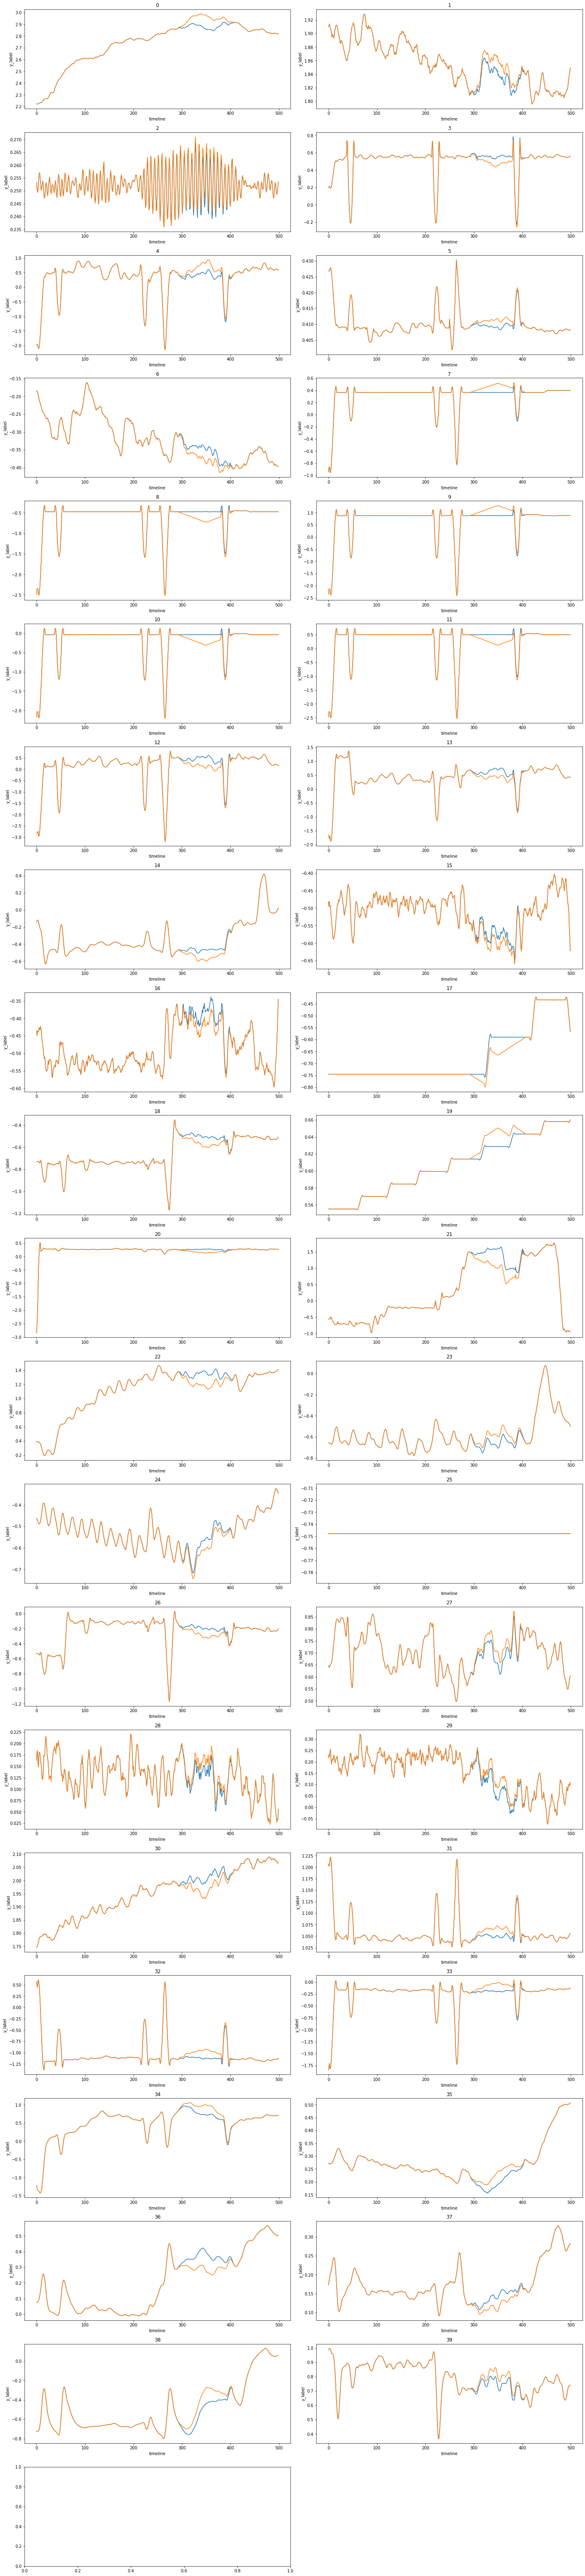

In [8]:
display_signal_with_anomalies(samples=anomaly_signal_samples[1],
                              x_label='timeline', 
                              y_label='y_label',
                              figsize=(20,100), 
                              plot_size=(24,2))

In [ ]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Объясненная вариация по основному компоненту: [9.95773810e-01 2.62503845e-03 7.39191421e-04]


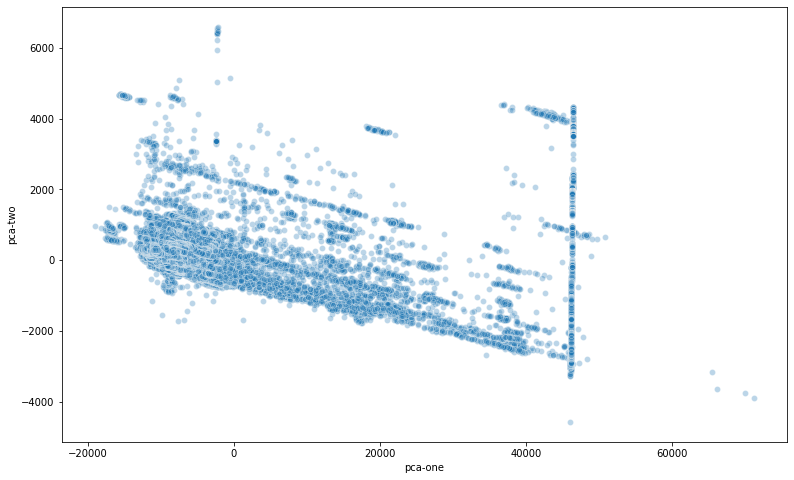

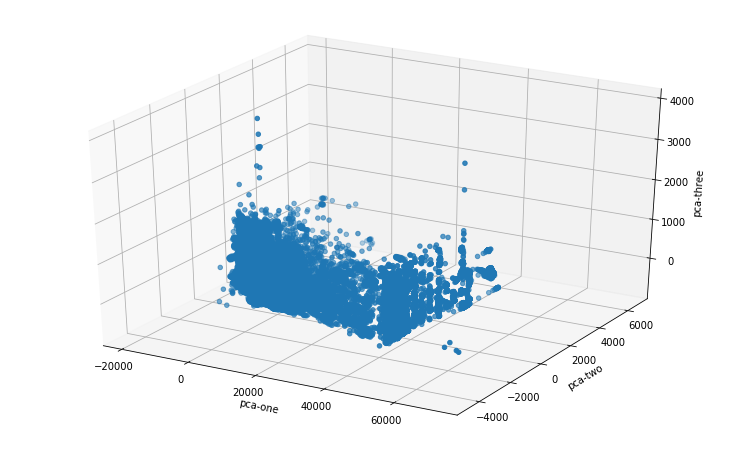

In [10]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(signals.control_results.values)

signals.control_results['pca-one'] = pca_result[:,0]
signals.control_results['pca-two'] = pca_result[:,1] 
signals.control_results['pca-three'] = pca_result[:,2]

print('Объясненная вариация по основному компоненту: {}'.format(pca.explained_variance_ratio_))


plt.figure(figsize=(13,8))
sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 10),
    data=signals.control_results,
    legend="full",
    alpha=0.3
)

ax = plt.figure(figsize=(13,8)).gca(projection='3d')
ax.scatter(
    xs=signals.control_results["pca-one"], 
    ys=signals.control_results["pca-two"], 
    zs=signals.control_results["pca-three"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# 2) Kaspersky gasoline technology process dataset chart